# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import requests
import datetime
import statsmodels.api as sm
from scipy.stats import t

import scipy as sp
import scipy.stats as sps
import scipy.optimize as spop

In [2]:
import warnings
warnings.filterwarnings("ignore")

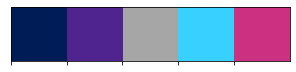

In [3]:
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

# Upload Data

### Load API

In [5]:
%cd /content
from google.colab import files
import io
import json

uploaded = files.upload()

file = io.BytesIO(uploaded['alpha_api.json'])
credentials = json.load(file)
api_key = credentials['api_key']

/content


Saving alpha_api.json to alpha_api.json


### Upload per stock

In [6]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&apikey={api_key}&outputsize=full'
r = requests.get(url)
data_apple = r.json()

In [7]:
df_apple = pd.DataFrame(data_apple['Time Series (Daily)'])
df_apple = df_apple.swapaxes('index', 'columns')
df_apple['symbol'] = 'AAPL'

In [8]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=Meta&apikey={api_key}&outputsize=full'
r = requests.get(url)
data_fb = r.json()

In [9]:
df_fb = pd.DataFrame(data_fb['Time Series (Daily)'])
df_fb = df_fb.swapaxes('index', 'columns')
df_fb['symbol'] = 'Meta'

In [10]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GOOGL&apikey={api_key}&outputsize=full'
r = requests.get(url)
data_g = r.json()

In [11]:
df_g = pd.DataFrame(data_g['Time Series (Daily)'])
df_g = df_g.swapaxes('index', 'columns')
df_g['symbol'] = 'GOOGL'

### Combine

Taking last 10 years (starting 26 aug 2012) and concatenating

In [12]:
df_fb.index = pd.to_datetime(df_fb.index)
df_g.index = pd.to_datetime(df_g.index)
df_apple.index = pd.to_datetime(df_apple.index)

In [13]:
df_fb = df_fb[df_fb.index.date > datetime.date(2012, 8, 23)]
df_g = df_g[df_g.index.date > datetime.date(2012, 8, 23)]
df_apple = df_apple[df_apple.index.date > datetime.date(2012, 8, 23)]

In [14]:
len(df_fb), len(df_g), len(df_apple)

(2520, 2520, 2520)

In [15]:
df = pd.concat([df_fb, df_g, df_apple])

In [16]:
# rename columns
df.columns = ['open', 'high', 'low', 'close', 'volume', 'symbol']

In [17]:
# change dtypes
df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype('float64')
df['volume'] = df['volume'].astype('int64')

In [18]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
symbol    0
dtype: int64

In [19]:
df.duplicated().sum()

0

### To CSV file

In [20]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [21]:
# %cd /content
# df.to_csv('stocks_data_10y.csv', index_label=False)
# !cp stocks_data_10y.csv "/gdrive/MyDrive/"

In [22]:
df = pd.read_csv('/gdrive/MyDrive/stocks_data_10y.csv')
df.index = pd.to_datetime(df.index)
df.head()

,open,high,low,close,volume,symbol
2022-08-29,160.655,163.05,159.0100,159.17,19771863,Meta
2022-08-26,168.480,170.92,161.6726,161.78,24023633,Meta
2022-08-25,165.180,168.88,164.0200,168.78,15550514,Meta
2022-08-24,160.600,165.46,159.7700,163.26,20891481,Meta
2022-08-23,162.480,165.05,160.7000,161.11,18111777,Meta


# Tasks

In [23]:
# backup
temp_df = df.copy()
# df = temp_df.copy()

## Daily returns

In [24]:
df = df.sort_index()

In [25]:
df_group = df.groupby('symbol')['close']
shifted = df_group.shift(1) # the day before

In [26]:
df['return'] = (shifted / df.close) - 1

In [27]:
# df['return'] = df.groupby('symbol')['close'].pct_change(1) # or we could use built-in function

In [28]:
fdf = df.copy() # full df with NaN in return
df = df[3:] # exclude 3 missing values

In [29]:
df.head()

,open,high,low,close,volume,symbol,return
2012-08-27,662.9900,672.00,659.240,669.22,5222100,GOOGL,0.014061
2012-08-27,19.4900,19.53,19.100,19.15,20704000,Meta,0.013525
2012-08-27,679.9900,680.87,673.540,675.68,15250300,AAPL,-0.018438
2012-08-28,19.1000,19.38,18.950,19.34,25417000,Meta,-0.009824
2012-08-28,674.9773,676.10,670.673,674.80,9550600,AAPL,0.001304


## Distribution

In [30]:
symbols = df.symbol.unique()
symbols

array(['GOOGL', 'Meta', 'AAPL'], dtype=object)

In [31]:
grouped_return = df.groupby('symbol')['return'].describe()
grouped_return

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,2518.0,0.002901,0.131818,-0.106990,-0.010201,-0.000671,0.007588,5.889755
GOOGL,2518.0,0.007527,0.389535,-0.139847,-0.008891,-0.000837,0.006646,19.503990
Meta,2518.0,-0.000550,0.024034,-0.228441,-0.012384,-0.001054,0.009713,0.358513


In [32]:
# skewness
for i in symbols:
  print(i, round(sps.skew(df[df['symbol'] == i]['return']), 3))

GOOGL 49.829
Meta 1.261
AAPL 39.478


In [33]:
# kurtosis
for i in symbols:
  print(i, round(sps.kurtosis(df[df['symbol'] == i]['return']), 3))

GOOGL 2491.18
Meta 29.83
AAPL 1666.778


### Distributions analysis

Credit for next peace of code goes to https://www.youtube.com/watch?v=KFM9iO8QkPM


________________________________________________
GOOGL
P-values:
{'normal': 0.0, 'laplas': 0.0, 'hypersecant-MM': 0.0, 'hypersecant-MLE': 0.0632, 'cauchy-MM': 0.0, 'cauchy-MLE': 0.0012, 'student': 0.0, 'logistic-MM': 0.0, 'logistic-MLE': 0.0}

hypersecant-MLE GOOGL

supremum 0.0331
p-value 0.0632
distribution is not valid


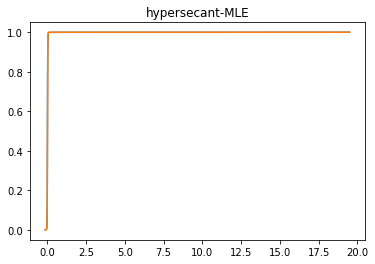

________________________________________________
Meta
P-values:
{'normal': 0.0, 'laplas': 0.2832, 'hypersecant-MM': 0.0007, 'hypersecant-MLE': 0.1771, 'cauchy-MM': 0.0, 'cauchy-MLE': 0.0027, 'student': 0.0034, 'logistic-MM': 0.0, 'logistic-MLE': 0.0222}

laplas Meta

supremum 0.0224
p-value 0.2832
distribution is valid


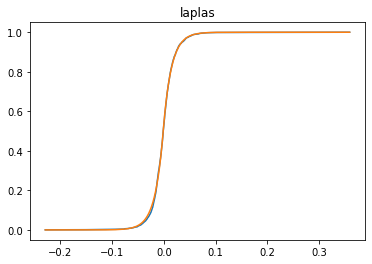

________________________________________________
AAPL
P-values:
{'normal': 0.0, 'laplas': 0.0002, 'hypersecant-MM': 0.0, 'hypersecant-MLE': 0.0, 'cauchy-MM': 0.0007, 'cauchy-MLE': 0.0011, 'student': 0.0, 'logistic-MM': 0.0, 'logistic-MLE': 0.0}

cauchy-MLE AAPL

supremum 0.0519
p-value 0.0011
distribution is not valid


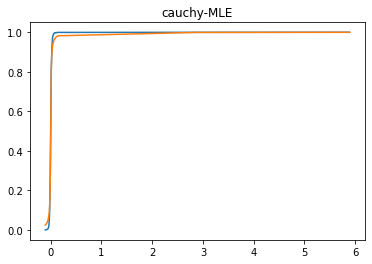

In [34]:
for i in symbols:
  data = pd.DataFrame()
  data[0] = df[df['symbol'] == i]['return']

  # rank samples from lower to calculate emperical distribution function
  data['rank']=(data[0].rank(method='first'))/(len(data))
  data=data.sort_values(by='rank').reset_index(drop=True)

  # calculate most important statistics
  mean = np.average(data[0])
  med = np.median(data[0])
  std = np.std(data[0])
  var = std**2
  skew = sps.skew(data[0])
  kurt = sps.kurtosis(data[0])

  # evaluate Laplas distribution parameters using method of maximum likelihood
  loc_laplace = med
  scale_laplace = np.average(abs(data[0]-med))

  # evaluate method of Cauchy distribution using method of moments
  loc_cauchy = med
  scale_cauchy = (np.percentile(data[0],0.75)-np.percentile(data[0],0.25))/2

  # evaluate paramenters of Cauchy distribution using method of maximum likelihood
  def cauchy_mle(k):
      return -np.sum(np.log(1/(np.pi*k[1]*(1 + ((data[0]-k[0])/k[1])**2))))
  res = spop.minimize(cauchy_mle, [loc_cauchy, scale_cauchy], method='Powell')
  loc_cauchy_mle = res.x[0]
  scale_cauchy_mle = res.x[1]

  # evaluate parameters of hypersecant using method of maximum likelihood
  def hypersecant_mle(k):
      return -np.sum(np.log(np.pi/(k[1])*np.exp(np.pi/2*(data[0]-k[0])/k[1])/(1+np.exp(np.pi*(data[0]-k[0])/k[1]))))
  res = spop.minimize(hypersecant_mle, [mean, std], method='Powell')
  loc_hypersecant_mle = res.x[0]
  scale_hypersecant_mle = res.x[1]

  # evaluate parameters of logistic distribution using method of moments
  loc_logistic = mean
  scale_logistic = 3**(1/2)/np.pi*std

  # evaluate parameters of logistic disctribution using method of maximum likelihood
  def logistic_mle(k):
      return -np.sum(np.log(np.exp(-(data[0]-k[0])/k[1])/(k[1]*(1+np.exp(-(data[0]-k[0])/k[1]))**2)))
  res = spop.minimize(logistic_mle, [loc_logistic, scale_logistic], method='Powell')
  loc_logistic_mle = res.x[0]
  scale_logistic_mle = res.x[1]

  # evaluate parameters of Student distribution using method of moments
  df_student = 6/kurt + 4
  loc_student = mean
  scale_student = std*((df_student - 2)/df_student)**(1/2)


  # create columns with functions of theoretical distributions based on evaluated parameters
  data['normal']=sps.norm.cdf(data[0],loc=mean,scale=std)
  data['cauchy-MM']=1/np.pi*np.arctan((data[0]-loc_cauchy)/scale_cauchy)+1/2
  data['cauchy-MLE']=1/np.pi*np.arctan((data[0]-loc_cauchy_mle)/scale_cauchy_mle)+1/2
  data['laplas1']=1/2*np.exp((data[data[0]<=loc_laplace][0]-med)/scale_laplace)
  data['laplas2']=1-1/2*np.exp(-(data[data[0]>med][0]-loc_laplace)/scale_laplace)
  data['laplas']=data['laplas1'].replace(np.nan,0)+data['laplas2'].replace(np.nan,0)
  data['hypersecant-MM']=2/np.pi*np.arctan(np.exp(np.pi*(data[0]-mean)/(2*std)))
  data['hypersecant-MLE']=2/np.pi*np.arctan(np.exp(np.pi*(data[0]-loc_hypersecant_mle)/(2*scale_hypersecant_mle)))
  data['student']=sps.t.cdf((data[0]-loc_student)/(scale_student),df_student,loc=0,scale=1)
  data['logistic-MM']=1/(1+np.exp(-(data[0]-loc_logistic)/scale_logistic))
  data['logistic-MLE']=1/(1+np.exp(-(data[0]-loc_logistic_mle)/scale_logistic_mle))

  # compare theoretical functions with emperic ones for each distribution
  distributions = ['normal', 'laplas', 'hypersecant-MM', 'hypersecant-MLE', 'cauchy-MM', 'cauchy-MLE', 'student', 'logistic-MM', 'logistic-MLE']

  # separate plots between symbols
  print('________________________________________________')
  print(i)

  pvalues = {}
  supremums = {}
  for dist in distributions:
    
    # calculate supremum
    KS_array = abs(data['rank']-data[dist])
    KS = max(KS_array)
    
    # calculate p-value (probability of data to follow this distribution)
    KS_p = np.exp(-KS**2*len(data))
    pvalues[dist] = KS_p
    supremums[dist] = KS

  pvalues = {k: round(v, 4) for k, v in pvalues.items()}
  supremums = {k: round(v, 4) for k, v in supremums.items()}
  pvalues_max = max(pvalues, key=pvalues.get)
  supremums_max = max(supremums, key=supremums.get)

  print('P-values:')
  print(pvalues)

  # visualize distributions with highest p-value
  print()
  print(pvalues_max, i)
  print()
  print('supremum '+str(supremums[pvalues_max]))
  print('p-value '+str(max(pvalues.values())))
  if pvalues[pvalues_max] > 0.1:
      print('distribution is valid')
  else:
      print('distribution is not valid')
  plt.figure(pvalues_max)
  plt.plot(data[0],data['rank'])
  plt.plot(data[0],data[pvalues_max])
  plt.title(pvalues_max)
  plt.show()

Based on research above, we can tell that:
- Google return distribution can be best described by Hypersecant-MLE (Maximum likelihood estimation)
- Meta return distribution can be best described by Laplas distribution (Hypersecant-MLE also showed p-value above 0.1)
- AAPL return distribution can be best described by Cauchy-MLE (Maximum likelihood estimation)  

However, only Meta return distribution's p-value is above 0.1 (0.28), other p-values are pretty low

### Stationarity

#### AAPL

In [35]:
AAPL = df[df['symbol'] == 'AAPL']['return']
Meta = df[df['symbol'] == 'Meta']['return']
GOOGL = df[df['symbol'] == 'GOOGL']['return']

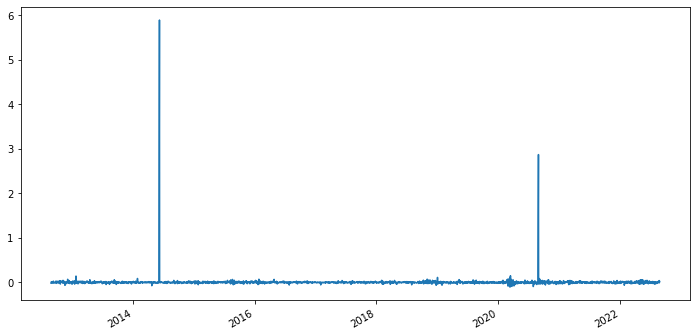

In [36]:
AAPL.plot(figsize=(12,6))

In [37]:
test = sm.tsa.adfuller(AAPL)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Not statinary')
else:
    print('Stationary')

adf:  -50.372600885538866
p-value:  0.0
Critical values:  {'1%': -3.4329507078222634, '5%': -2.8626889823128554, '10%': -2.567381647203466}
Stationary


#### Meta

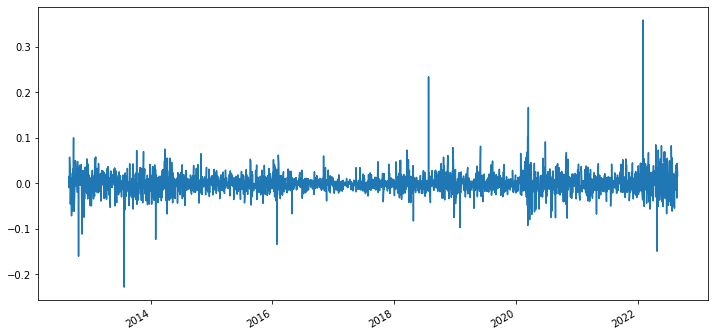

In [38]:
Meta.plot(figsize=(12,6))

In [39]:
test = sm.tsa.adfuller(Meta)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Not statinary')
else:
    print('Stationary')

adf:  -17.306509570866336
p-value:  5.5876903333150976e-30
Critical values:  {'1%': -3.432959008741782, '5%': -2.862692648021296, '10%': -2.567383598871881}
Stationary


#### GOOGL

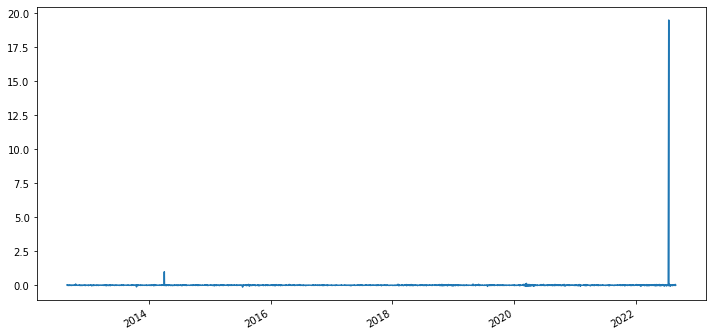

In [40]:
GOOGL.plot(figsize=(12,6))

In [41]:
test = sm.tsa.adfuller(GOOGL)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Not statinary')
else:
    print('Stationary')

adf:  -50.307855852460065
p-value:  0.0
Critical values:  {'1%': -3.4329507078222634, '5%': -2.8626889823128554, '10%': -2.567381647203466}
Stationary


Based on research above, we can conclude that all time series are stationary, which means that  
**its' properties doesn't depend on the time at which time series are observed**  

## Granger Causality

In [42]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''
    
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

Rank of Matrix: 6
Determinant of matrix: 0.0
Shape of matrix: (6, 6)


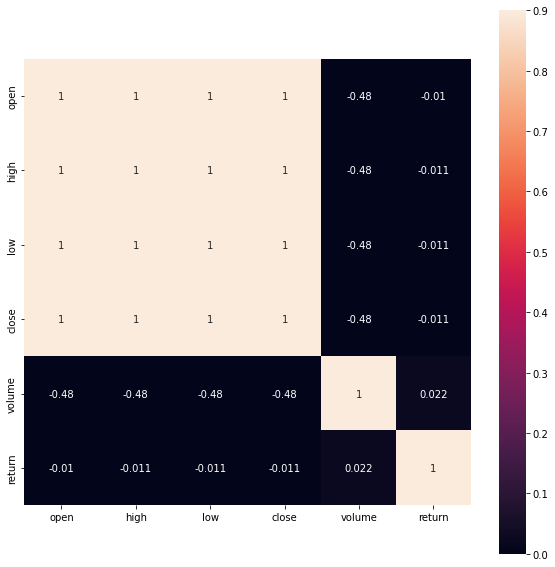

In [43]:
corr_matrix(df)

Slightly higher correlation between volume and return, let's check with Granger Causality

In [44]:
from statsmodels.tsa.stattools import grangercausalitytests

dict_of_p1 = {}
dict_of_p2 = {}
for i in df.drop(['return', 'symbol'], axis=1).columns:
  dict_of_p1[i] = round(grangercausalitytests(df[['return', i]], maxlag=[3])[3][0]['ssr_ftest'][1], 4)
  dict_of_p2[i] = round(grangercausalitytests(df[[i, 'return']], maxlag=[3])[3][0]['ssr_ftest'][1], 4)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1464  , p=0.0922  , df_denom=7544, df_num=3
ssr based chi2 test:   chi2=6.4453  , p=0.0918  , df=3
likelihood ratio test: chi2=6.4425  , p=0.0920  , df=3
parameter F test:         F=2.1464  , p=0.0922  , df_denom=7544, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9379  , p=0.4213  , df_denom=7544, df_num=3
ssr based chi2 test:   chi2=2.8163  , p=0.4208  , df=3
likelihood ratio test: chi2=2.8157  , p=0.4209  , df=3
parameter F test:         F=0.9379  , p=0.4213  , df_denom=7544, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1371  , p=0.0933  , df_denom=7544, df_num=3
ssr based chi2 test:   chi2=6.4172  , p=0.0930  , df=3
likelihood ratio test: chi2=6.4144  , p=0.0931  , df=3
parameter F test:         F=2.1371  , p=0.0933  , df_denom=7544, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9410  , p=0.

In [45]:
print(dict_of_p1)
print(dict_of_p2)

{'open': 0.0922, 'high': 0.0933, 'low': 0.0935, 'close': 0.0965, 'volume': 0.5274}
{'open': 0.4213, 'high': 0.4198, 'low': 0.408, 'close': 0.4061, 'volume': 0.0051}


Based on findings, if we say that significance value is a>0.1  
we can conclude that **'volume'** Granger-causes **'return'**

## Profit-and-loss

In [46]:
# https://www.askpython.com/python/normal-distribution
def normal_dist(x , mean , std):
    prob_density = (np.pi*std) * np.exp(-0.5*((x-mean)/std)**2)
    return prob_density

mean = 0
std = 1

In [47]:
x = df[df['symbol'] == 'AAPL']['return'].shift(1) # shift backwards ( the day before )
pdf = normal_dist(x,mean,std)

ap_df = pd.DataFrame(pdf)

In [48]:
x = df[df['symbol'] == 'Meta']['return'].shift(1)
pdf = normal_dist(x,mean,std)

met_df = pd.DataFrame(pdf)

In [49]:
x = df[df['symbol'] == 'GOOGL']['return'].shift(1)
pdf = normal_dist(x,mean,std)

gog_df = pd.DataFrame(pdf)

In [50]:
norm_forecast = pd.concat([ap_df, met_df, gog_df]).sort_index()
norm_forecast.columns = ['forecast']

In [52]:
forc_df = pd.concat([df, norm_forecast], axis=1)

In [53]:
forc_df['pnl'] = forc_df['forecast'] * forc_df['return']

pnl-i plot



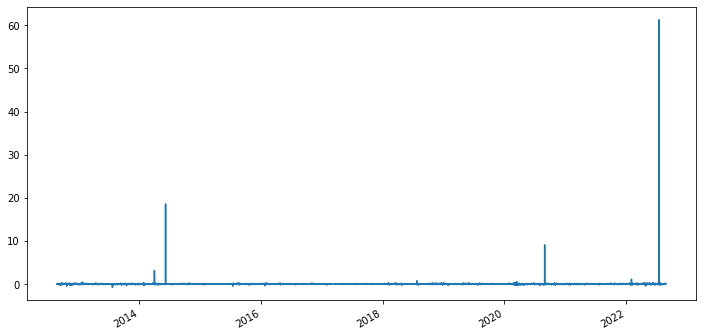

In [54]:
forc_df.pnl.plot(figsize=(12,6))

pnl = cumsum(pnl-i) plot

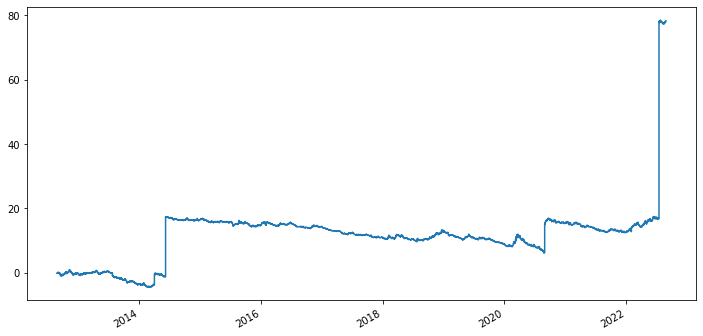

In [55]:
forc_df.cumsum()['pnl'].plot(figsize=(12,6))

## Sharpe Ratio

In [56]:
# https://medium.datadriveninvestor.com/the-sharpe-ratio-with-python-from-scratch-fbb1d5e490b9
# Sharpe Ratio From Scratch
def sharpe_ratio(data, risk_free_rate=0.0):
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = data.std()
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    
    return sharpe_ratio

In [57]:
AAPL = df[df['symbol'] == 'AAPL']
Meta = df[df['symbol'] == 'Meta']
GOOGL = df[df['symbol'] == 'GOOGL']

In [58]:
rolstd_AAPL = pd.Series(AAPL['return']).rolling(window=5).std()
rolstd_Meta = pd.Series(Meta['return']).rolling(window=5).std()
rolstd_GOOGL = pd.Series(GOOGL['return']).rolling(window=5).std()

In [59]:
AAPL['rol_std'] = rolstd_AAPL
Meta['rol_std'] = rolstd_Meta
GOOGL['rol_std'] = rolstd_GOOGL

In [61]:
AAPL['f_std'] = AAPL['return'] + rolstd_AAPL
Meta['f_std'] = Meta['return'] + rolstd_Meta
GOOGL['f_std'] = GOOGL['return'] + rolstd_GOOGL

In [66]:
AAPL['pnl'] = AAPL['f_std'] * AAPL['return']
Meta['pnl'] = Meta['f_std'] * Meta['return']
GOOGL['pnl'] = GOOGL['f_std'] * GOOGL['return']

In [67]:
def return_hit(row):
  if (row['return'] > 0) & (row['pnl'] > 0) | ((row['return'] < 0) & (row['pnl'] < 0)):
    return 1
  else:
    return 0

In [70]:
AAPL['hit_rate'] = AAPL.apply(return_hit, axis=1)
Meta['hit_rate'] = Meta.apply(return_hit, axis=1)
GOOGL['hit_rate'] = GOOGL.apply(return_hit, axis=1)

In [100]:
AAPL['hit_rate_roll'] = AAPL['hit_rate'].rolling(5).mean()
Meta['hit_rate_roll'] = Meta['hit_rate'].rolling(5).mean()
GOOGL['hit_rate_roll'] = GOOGL['hit_rate'].rolling(5).mean()

In [87]:
AAPL['sharpe'] = AAPL['pnl'].rolling(5).mean()/AAPL['pnl'].std()
Meta['sharpe'] = Meta['pnl'].rolling(5).mean()/Meta['pnl'].std()
GOOGL['sharpe'] = GOOGL['pnl'].rolling(5).mean()/GOOGL['pnl'].std()

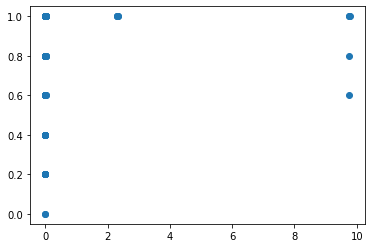

In [101]:
plt.scatter(AAPL['sharpe'], AAPL['hit_rate_roll'])

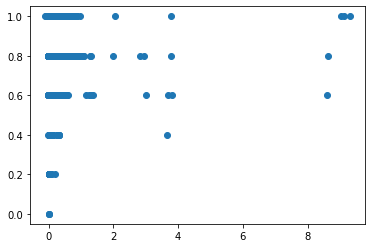

In [102]:
plt.scatter(Meta['sharpe'], Meta['hit_rate_roll'])

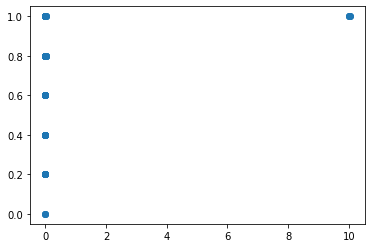

In [103]:
plt.scatter(GOOGL['sharpe'], GOOGL['hit_rate_roll'])

## Classification model

In [104]:
data = pd.read_csv('/gdrive/MyDrive/xtask.csv')

In [105]:
data.head()

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       3839 non-null   float64
 1   b       3839 non-null   float64
 2   c       3839 non-null   float64
 3   d       3839 non-null   float64
 4   class   3071 non-null   float64
dtypes: float64(5)
memory usage: 150.1 KB


In [110]:
data['class'].value_counts()

1.0    2026
0.0    1045
Name: class, dtype: int64

In [115]:
#@title
def make_confusion_matrix(cf,
                          group_names=['TN', 'FP', 'FN', 'TP'],
                          categories='auto',
                          sum_stats=True,
                          count=True,
                          cbar=True,
                          percent=True,
                          cmap='BuPu'):
    '''Function is called for making a confusion matrix
    args
    ------
    cf - confusion matrix
    group_names - Names for each group
    categories -  categories to be displayed on the x,y axis. Default is 'auto'
    sum_stats -   shows Accuracies. Deafult is TRUE
    c_bar -       If True, show the color bar. The cbar values are based off the values in the confusion matrix. 
                  Default is True
    percent -     to be displayed on the x,y axis. Default is True
    '''
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    group_labels = ["{}\n".format(value) for value in group_names]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # Metrics
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))
        ball_accuracy = .5 * (cf[1, 1] / sum(cf[1, :]) +
                              cf[0, 0] / sum(cf[0, :]))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # pr = how many real true
            precision = cf[1, 1] / sum(cf[:, 1])
            # How many positives from all positives
            recall = cf[1, 1] / sum(cf[1, :])
            # F1 score
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nBallancedAcc={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, ball_accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    plt.rcParams.get('figure.figsize')
    plt.figure(figsize=(5, 5))
    sns.heatmap(cf,
                annot=box_labels,
                fmt="",
                cmap=cmap,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

In [142]:
#@title
from sklearn.model_selection import cross_validate
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='test', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [207]:
from sklearn.model_selection import train_test_split, KFold

X = data[data['class'].notna()].drop(['class'], axis=1)
y = data[data['class'].notna()]['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

val = data[data['class'].isna()]

### RandomForestClassifier

In [113]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

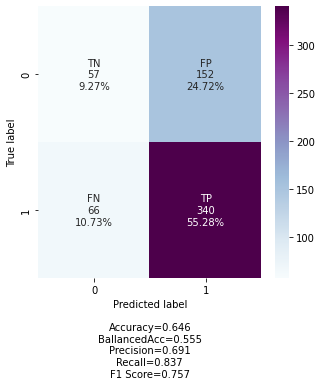

In [116]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, clf.predict(X_test))
make_confusion_matrix(cf)

[train] F1-score = 1.00 +/- 0.00
[valid] F1-score = 0.62 +/- 0.01


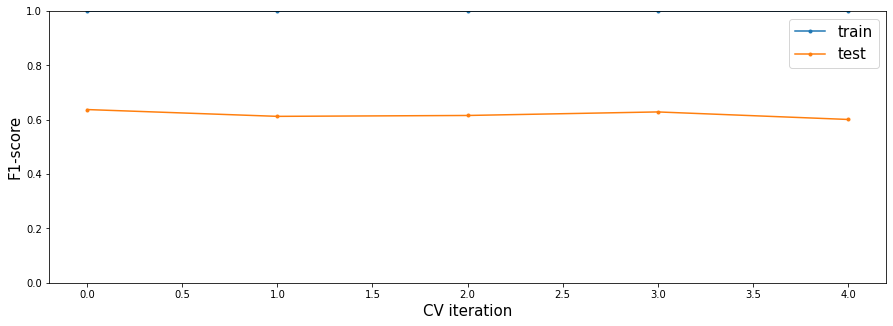

In [143]:
cv_metrics = cross_validate(clf, X, y, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

### Catboost

In [119]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [124]:
%cd /content

/content


In [126]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(random_state=42, verbose=False).fit(X_train, y_train)

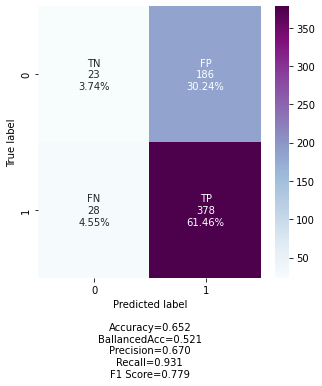

In [127]:
cf = confusion_matrix(y_test, cb.predict(X_test))
make_confusion_matrix(cf)

[train] F1-score = 0.78 +/- 0.01
[valid] F1-score = 0.64 +/- 0.01


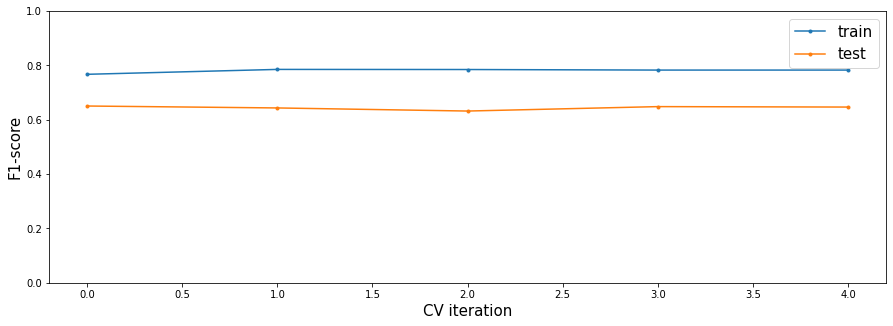

In [144]:
cv_metrics = cross_validate(cb, X, y, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

Both models seem to choose 1 in most cases, let's try over- and undersampling

### Undersampling

In [136]:
train, test = train_test_split(data[data['class'].notna()], stratify=data[data['class'].notna()]['class'], random_state=42)

In [148]:
train['class'].value_counts()

1.0    1519
0.0     784
Name: class, dtype: int64

In [165]:
minority = train['class'].value_counts()[0]
major_train = train[train['class'] == 1].sample(minority)
minor_train = train[train['class'] == 0]

In [166]:
train_u = pd.concat([major_train, minor_train])

In [168]:
train_u['class'].value_counts()

1.0    784
0.0    784
Name: class, dtype: int64

In [169]:
X_train_u = train_u.drop(['class'], axis=1)
y_train_u = train_u['class']
X_test_u = test.drop(['class'], axis=1)
y_test_u = test['class']

In [177]:
X_u = pd.concat([X_train_u, X_test_u])
y_u = pd.concat([y_train_u, y_test_u])

#### RandomForestClassifier

In [170]:
clf_u = RandomForestClassifier(random_state=42).fit(X_train_u, y_train_u)

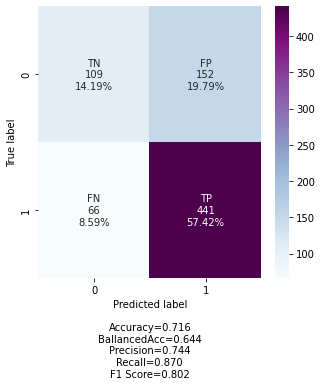

In [171]:
cf = confusion_matrix(y_test_u, clf.predict(X_test_u))
make_confusion_matrix(cf)

#### Catboost

In [175]:
cb_u = CatBoostClassifier(random_state=42, verbose=False).fit(X_train_u, y_train_u)

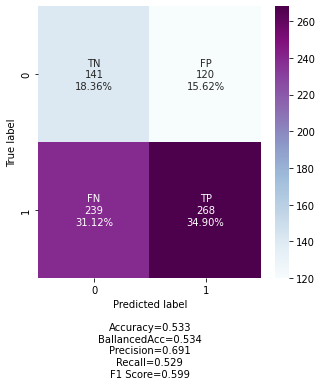

In [176]:
cf = confusion_matrix(y_test_u, cb_u.predict(X_test_u))
make_confusion_matrix(cf)

[train] F1-score = 0.86 +/- 0.01
[valid] F1-score = 0.53 +/- 0.02


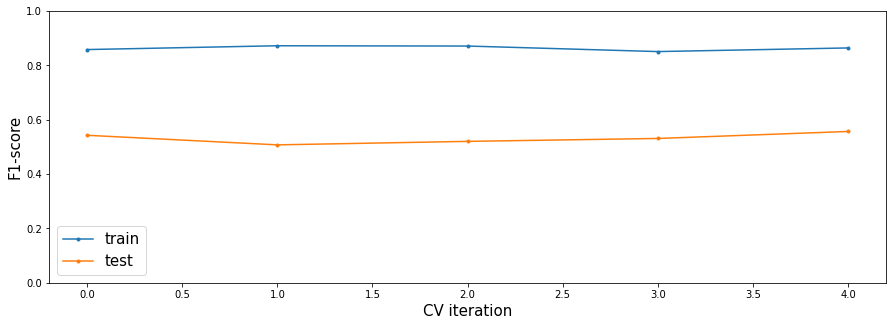

In [179]:
cv_metrics = cross_validate(cb_u, X_u, y_u, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

### Oversampling

In [180]:
from imblearn.over_sampling import RandomOverSampler

In [181]:
oversample = RandomOverSampler(sampling_strategy=1)
X_o, y_o = oversample.fit_resample(X, y)

In [185]:
X.value_counts()

a          b          c          d        
-0.995371  -0.054527  -0.079145  -0.000544    1
 0.260165  -0.069681   0.015202   0.962927    1
 0.256685   0.535921  -0.514542   0.586007    1
 0.257272   0.354813   0.705764  -0.479356    1
 0.257612   0.804621   0.429184  -0.265875    1
                                             ..
-0.273019  -0.498395  -0.631050  -0.528051    1
-0.272968  -0.142352   0.806060  -0.469581    1
-0.272424   0.426891  -0.736283  -0.448818    1
-0.272398   0.883536  -0.304277  -0.229301    1
 0.995987  -0.049802   0.033456  -0.066407    1
Length: 3071, dtype: int64

In [183]:
X_o.value_counts()

a          b          c          d        
 0.873037  -0.115199  -0.131265  -0.370957    6
 0.363277   0.752123  -0.048644  -0.519181    5
 0.655571   0.386336   0.509797  -0.223608    5
 0.431426  -0.046463   0.316378   0.802333    5
 0.228336   0.710467  -0.331836   0.523877    5
                                             ..
-0.216087   0.450691  -0.485170   0.717491    1
-0.215409  -0.280580   0.558889   0.750011    1
-0.215265   0.035068  -0.947816   0.232541    1
-0.214944   0.612120   0.024712  -0.760590    1
 0.995987  -0.049802   0.033456  -0.066407    1
Length: 3071, dtype: int64

In [186]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, random_state=42)

#### RandomForestClassifier

In [187]:
clf_o = RandomForestClassifier(random_state=42).fit(X_train_o, y_train_o)

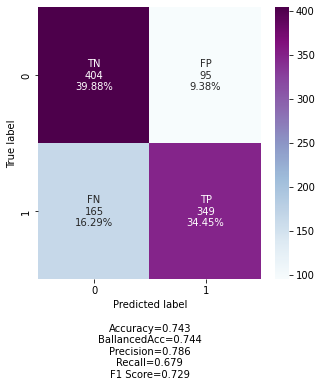

In [195]:
cf = confusion_matrix(y_test_o, clf_o.predict(X_test_o))
make_confusion_matrix(cf)

#### CatboostClassifier

In [189]:
cb_o = CatBoostClassifier(random_state=42, verbose=False).fit(X_train_o, y_train_o)

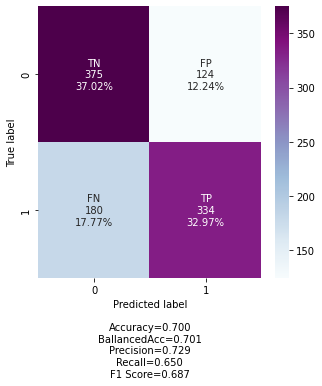

In [196]:
cf = confusion_matrix(y_test_o, cb_o.predict(X_test_o))
make_confusion_matrix(cf)

[train] F1-score = 0.89 +/- 0.01
[valid] F1-score = 0.72 +/- 0.04


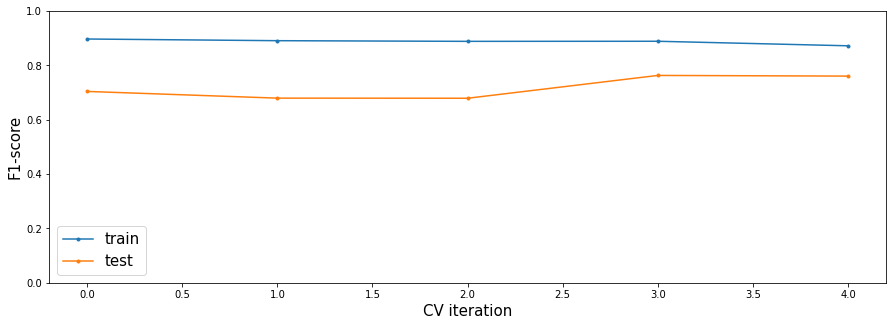

In [197]:
cv_metrics = cross_validate(cb_o, X_o, y_o, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

In [198]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_o = GradientBoostingClassifier(random_state=42).fit(X_o, y_o)

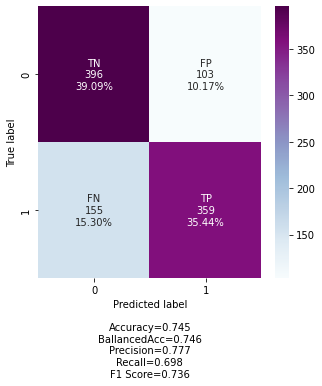

In [199]:
cf = confusion_matrix(y_test_o, gbc_o.predict(X_test_o))
make_confusion_matrix(cf)

In [202]:
from sklearn.ensemble import AdaBoostClassifier
ada_o = AdaBoostClassifier(random_state=42).fit(X_o, y_o)

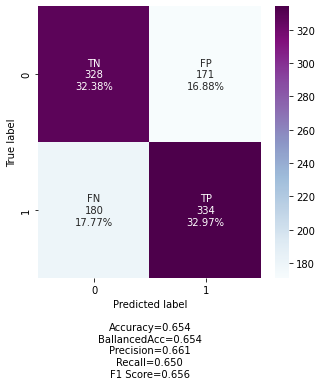

In [203]:
cf = confusion_matrix(y_test_o, ada_o.predict(X_test_o))
make_confusion_matrix(cf)

Oversampling shows better results in terms of TP/TN distribution, will use it for parameter tuning.

#### Stacking

In [279]:
from sklearn.base import clone

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    # StratifiedKFold(random_state=42, shuffle=True)
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train, y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train.values[train_fold_index], X_train.values[predict_fold_index]
        y_fold_train = y_train.values[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [280]:
from tqdm import tqdm
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [281]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [282]:
from sklearn.linear_model import LogisticRegression



seed = 42

# stack algorythms, generate meta features
stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, solver='saga', max_iter=2000, multi_class='ovr', random_state=seed),
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=seed),
    GradientBoostingClassifier(n_estimators=200, random_state=seed)
], X_train_o, X_test_o, y_train_o, cv)

# meta-classifier
clf = LogisticRegression(penalty='none', solver='lbfgs', random_state=seed)

100%|██████████| 3/3 [00:17<00:00,  5.83s/it]


In [283]:
clf.fit(stacked_features_train, y_train_o)

LogisticRegression(penalty='none', random_state=42)

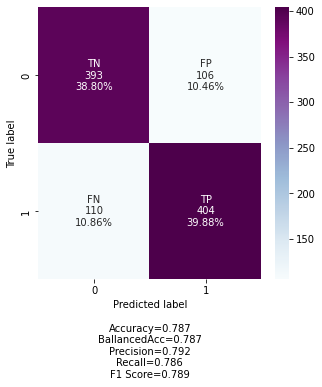

In [284]:
cf = confusion_matrix(y_test_o, clf.predict(stacked_features_test))
make_confusion_matrix(cf)

Stacking on oversampled data showed best results.  
Looks pretty balanced as well, will use it as final model

In [302]:
stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, solver='saga', max_iter=2000, multi_class='ovr', random_state=seed),
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=seed),
    GradientBoostingClassifier(n_estimators=200, random_state=seed)
], X_o, val.drop(['class'], axis=1), y_o, cv)

100%|██████████| 3/3 [00:21<00:00,  7.33s/it]


In [303]:
# meta-classifier
clf = LogisticRegression(penalty='none', solver='lbfgs', random_state=seed)
clf.fit(stacked_features_train, y_o)

LogisticRegression(penalty='none', random_state=42)

[train] F1-score = 0.51 +/- 0.01
[valid] F1-score = 0.50 +/- 0.01


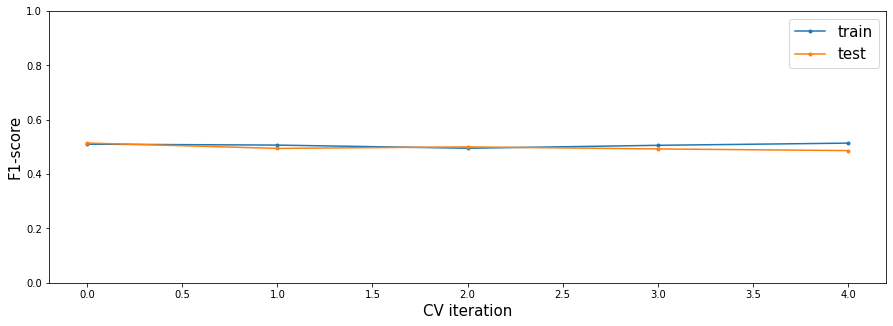

In [304]:
cv_metrics = cross_validate(clf, X_o, y_o, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

In [305]:
predicts = pd.Series(clf.predict(stacked_features_test))

In [306]:
predicts.to_csv('Y_test.csv')

In [307]:
!cp Y_test.csv '/gdrive/MyDrive'

## Conclusion

Best results could be reached by stacking 3 different models and training on oversampled data:
- LogisticRegression 
- RandomForestClassified 
- GradientBoostingClassifier 

Based on checks model is not overfit - same results on train and test.  
The only concern is that about 85% of the answers are '1', which didn't occur on previous testing. Might be real answers anyway.
